### Tips, Tricks, and Hacks

In the tutorial notebook, we learned how to make light curves for stars observed in a single sector or in multiple sectors. In this notebook we'll explore how to make the most of these data and ensure your signal is real.

#### 1.1 Choosing an Aperture

Let's begin with the same WASP-100 we used in the quickstart tutorial. I'm going to hide warnings too, just to make it easier to see what's going on.

In [1]:
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt

In [3]:
star = eleanor.Source(tic=38846515, sector=1)
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)
q = data.quality == 0

INFO: Found cached file /Users/bmontet/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file /Users/bmontet/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file /Users/bmontet/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-1_tess_v2_pm.txt with expected size 237847. [astroquery.query]




100%|██████████| 1282/1282 [00:10<00:00, 113.98it/s]


What if you're not satisfied with $\texttt{eleanor}$'s default choice of aperture? Well, we provide you with three ways to explore different apertures.

(1) All of the apertures $\texttt{eleanor}$ tries behind the scenes are saved! So are their raw and corrected light curves. These are stored as ```data.all_apertures```, ```data.all_raw_flux```, and ```data.all_corr_flux```, respectively. We can explore these options by calling the following, for example.

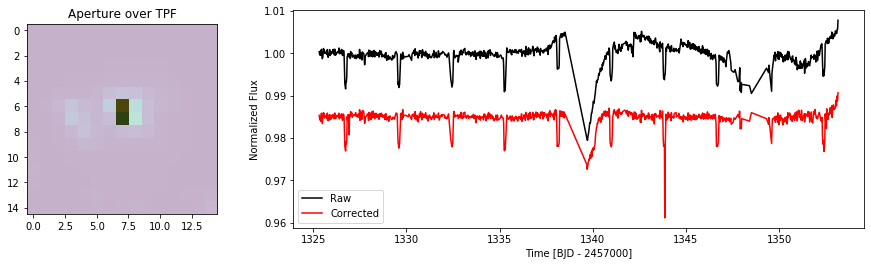

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.all_apertures[0], cmap='Greys', alpha=0.7)
ax1.set_title('Aperture over TPF')

ax2.plot(data.time[q], data.all_raw_flux[0][q]/np.nanmedian(data.all_raw_flux[0][q]), 'k', label='Raw')
ax2.plot(data.time[q], data.all_corr_flux[0][q]/np.nanmedian(data.all_corr_flux[0][q]) - 0.015, 'r', label='Corrected')
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux')
ax2.legend();

(2) $\texttt{eleanor}$ can help you create your own mask. By calling `eleanor.custom_aperture()`, we can choose from a circular or rectangular aperture. We can also choose the size (radius or length x width) and the pixel the aperture is centered on by passing in a list of $\textit{(x,y)}$ to `pos`. The aperture will only be created on pixels within the TPF (it won't spill over to other pixels). Calling `eleanor.custom_aperture()` overwrites `eleanor.TargetData.aperture`, `eleanor.TargetData.raw_flux`, and `eleanor.TargetData.corr_flux`.

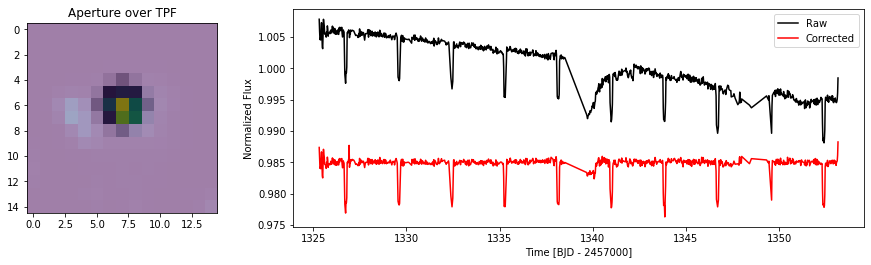

In [5]:
eleanor.TargetData.custom_aperture(data, shape='circle', r=2, pos=[7,6], method='exact')
eleanor.TargetData.get_lightcurve(data)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax2.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q]), 'k', label='Raw')
ax2.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) - 0.015, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

(3) We can pass in our own mask by creating a 2D array of the same shape as the TPF and calling eleanor.TargetData.get_lightcurve(aperture=mask)

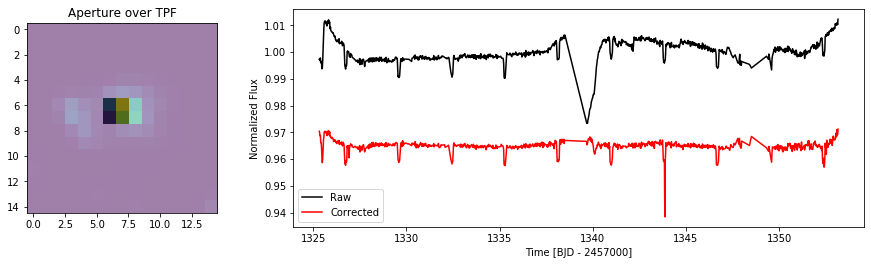

In [6]:
mask = np.zeros(np.shape(data.tpf[0]))
mask[6:8,6:8] = 1
data.get_lightcurve(aperture=mask)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(mask, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax2.plot(data.time[q], data.raw_flux[q]/np.nanmedian(data.raw_flux[q]), 'k', label='Raw')
ax2.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) - 0.035, 'r', label='Corrected')
ax2.legend()
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

#### 1.2 Adding or Removing Flux Correction Terms

When we call eleanor.TargetData(), some simple systematics corrections are automatically performed on the light curve. Let's apply those explicitly to the newly created raw light curve from the custom aperture and see how we can change them.

In [7]:
corr_flux = eleanor.TargetData.corrected_flux(data, flux=data.raw_flux)

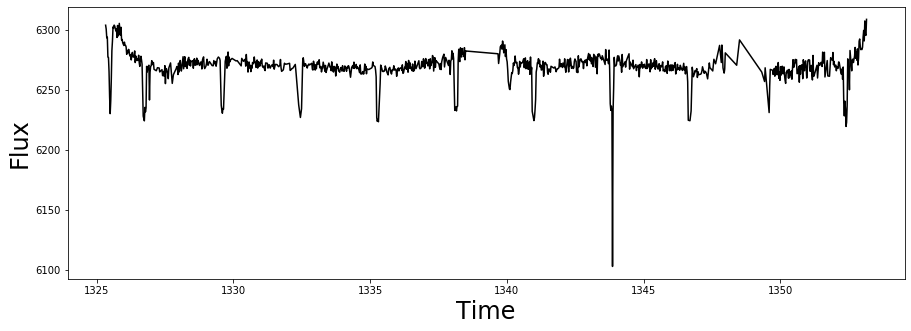

In [8]:
plt.figure(figsize=(15,5))
plt.plot(data.time[q], corr_flux[q], 'k')

plt.ylabel('Flux', fontsize=24)
plt.xlabel('Time', fontsize=24);

##### 1.2.1 Changing quality flags

If we think certain data are bad, but not quality flagged, we can give them a different quality label and re-run this function, causing them to be ignored so they do not influence other cadences. By default, all highest quality data have flag zero and all other flags are positive. Let's throw out a four-day chunk temporarily:

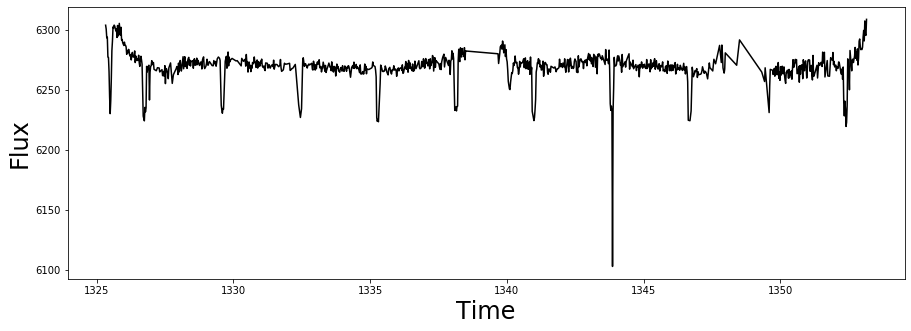

In [9]:
data.quality[q][(data.time[q] > 1333) & (data.time[q] < 1337)] = -8675309
corr_flux = eleanor.TargetData.corrected_flux(data, flux=data.raw_flux)

q = data.quality <= 0.5

plt.figure(figsize=(15,5))
plt.plot(data.time[q], corr_flux[q], 'k')

plt.ylabel('Flux', fontsize=24)
plt.xlabel('Time', fontsize=24);


##### 1.2.2 Removing terms from the model

By default, the ```corrected_flux``` function removes signals that are correlated with the position of the star on the detector, with common modes of nearby stars, and with the background. We can stop these from being a part of ```corrected_flux``` by setting them to zero.

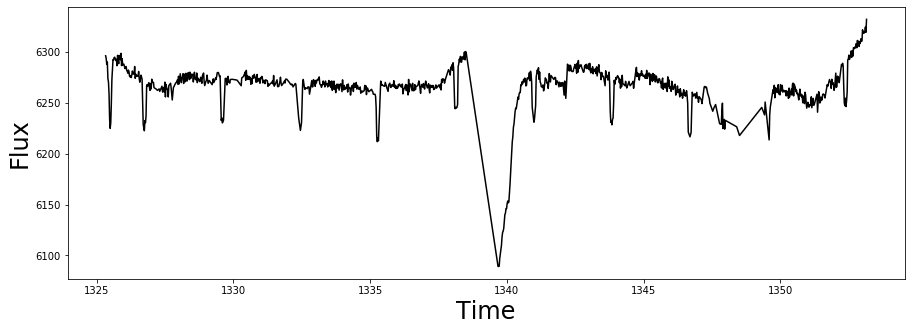

In [10]:
data.cbvs = np.zeros_like(data.cbvs)
data.centroid_xs = np.zeros_like(data.centroid_xs)
data.centroid_ys = np.zeros_like(data.centroid_ys)

corr_flux = eleanor.TargetData.corrected_flux(data, flux=data.raw_flux)

plt.figure(figsize=(15,5))
plt.plot(data.time[q], corr_flux[q], 'k')

plt.ylabel('Flux', fontsize=24)
plt.xlabel('Time', fontsize=24);

In this case, we have a noisier light curve that looks more like the raw flux.

We can always get back to where we started by just re-running ```eleanor.TargetData()``` with the same call we used initially.

In [11]:
data = eleanor.TargetData(star, height=15, width=15, bkg_size=31, do_psf=True, do_pca=True)

100%|██████████| 1282/1282 [00:11<00:00, 114.33it/s]


##### 1.2.3 Adding new terms to the model

What if you have additional information that you believe might be correlated with the star's raw flux? You can add these in to the ```corrected_flux``` function as ```regressors```. Any $N$ regressors can be passed through as an array with shape (```data.time, N```).

For example, we've found that often, some of the parameters that describe the shape of the PSF make very good regressors to produce a clean, systematics-corrected light curve:

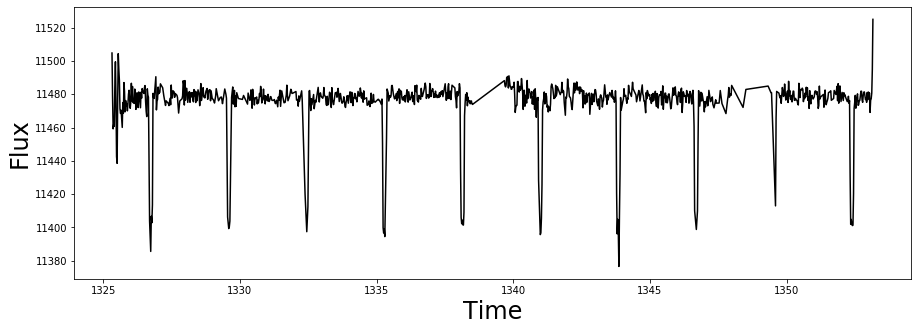

In [12]:
reg_array = np.array([data.psf_b, data.psf_c, data.psf_x]).T
corr_flux = eleanor.TargetData.corrected_flux(data, flux=data.raw_flux, regressors=reg_array)

plt.figure(figsize=(15,5))
plt.plot(data.time[q], corr_flux[q], 'k')

plt.ylabel('Flux', fontsize=24)
plt.xlabel('Time', fontsize=24);

You could also regress against nearby pixels, other stars, random noise, or any other length ```data.time``` array you can imagine.

#### 1.3 Making a PSF-based light curve

By setting ```do_psf = True``` in your call to ```eleanor.TargetData()```, you can model the PSF as a single 2D Gaussian that can change shape or position from cadence to cadence.

In [13]:
eleanor.TargetData.psf_lightcurve(data, model='gaussian')

100%|██████████| 1282/1282 [00:10<00:00, 118.43it/s]


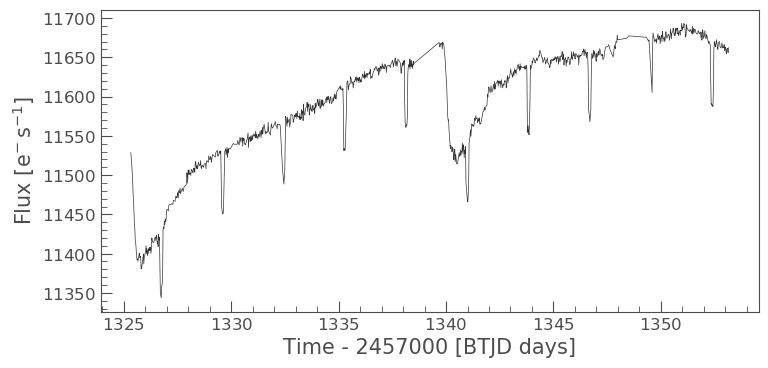

In [14]:
lk = data.to_lightkurve(flux=data.psf_flux)
lk.plot();

There are a few tricks we can use to improve this light curve. This is an incomplete list, check the docs for full details.

For this star, there are two bright stars in the TPF. We can model them both simultaneously by passing through ```nstars=2``` and giving an initial guess on their positions. The code will keep the relative positions of the two stars fixed, moving both of them from cadence to cadence in the same way.

In [15]:
eleanor.TargetData.psf_lightcurve(data, model='gaussian', nstars=2, xc=[3.1, 7.0], yc=[6.8, 6.2])

100%|██████████| 1282/1282 [00:14<00:00, 87.74it/s]


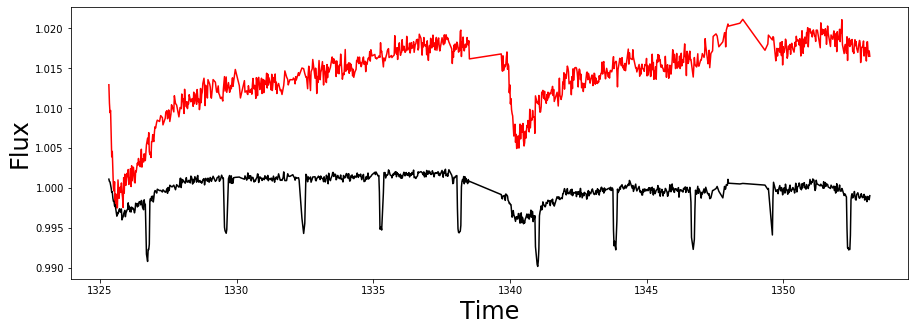

In [16]:
plt.figure(figsize=(15,5))
plt.plot(data.time[q], data.all_psf[q,0]/np.nanmedian(data.all_psf[q,0])+0.015, 'r')
plt.plot(data.time[q], data.all_psf[q,1]/np.nanmedian(data.all_psf[q,1]), 'k')


plt.ylabel('Flux', fontsize=24)
plt.xlabel('Time', fontsize=24);

In this case, we can tell very obviously what star the transit is on!

We can also pass through a different error array, request a Moffat profile model, a Poisson likelihood function, or even pass through a different TPF! 

#### 1.4 Running eleanor locally/without internet

With the default settings, `eleanor` will attempt to find the proper postcard for your target, as well as other data about your system, through MAST. If you don't have internet access, but have downloaded your postcard already (if you've made a light curve for your star of interest previously, you may already have the postcard in your `~/.eleanor` directory), you can avoid all need for the internet with a few simple tricks.

All you need to do are pass through `local = True` in your call to `eleanor.Source()` and give the directory of your postcard and pointing model. By default, these are downloaded to the same directory. If you don't pass through a pointing model directory, it will assume it's in the same place as your postcard. I've put mine in `../../testdir1` and `../../testdir2`, respectively.

You also need to pass through your star's coordinates. Normally you can pass through one of a name, TIC ID, Gaia DR2, ID, or coordinates. In these cases, behind the scenes `eleanor` will use any one of these to get the rest of this information, but behind the scenes relies on the coordinates. You need to pass through the other values as well, but just so they're set to something so `eleanor` doesn't try to look them up. You can set them to zero, that's fine.

In [17]:
coords = (68.959732, -64.02704)
star = eleanor.Source(coords=coords, tic=0, gaia=0, sector=1, local=True, post_dir='./testdir1', pm_dir='./testdir2')
data = eleanor.TargetData(star, do_pca=True, do_psf=False)

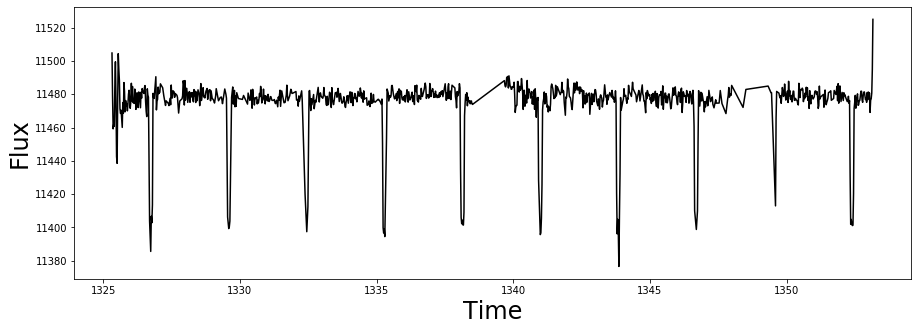

In [18]:
plt.figure(figsize=(15,5))

q = data.quality == 0
plt.plot(data.time[q], corr_flux[q], 'k')

plt.ylabel('Flux', fontsize=24)
plt.xlabel('Time', fontsize=24);

The only thing that will be missing is `star.tess_mag`, but you can set that yourself too before you run `data.save()` and it will be recorded properly.

In [19]:
star.tess_mag = 10.53

#### 1.5 Targets without TIC IDs

When you pass through ```coords``` into `eleanor.Source()`, it will use these coordinates to find the TIC entry at that location. However, some targets (often very faint or non-stellar in nature) do not appear in the TIC. This will produce an error that inhibits ```eleanor.Source()``` from running successfully. However, as we noted in the previous section, `eleanor` does not use the TIC ID behind the scenes. Passing through a false TIC ID and the proper coordinates will work just fine.

#### 1.6 Saturated targets

`eleanor` tests a variety of apertures and selects the one with the lowest CDPP. Very saturated targets ($T < 6-7$, depending on location on the detector) have many pixels at the saturation limit. Choosing a small number of saturated pixels will then produce a very stable light curve, leading `eleanor` to choose very small apertures that do not represent the true astrophysical variability from these sources. To make light curves from these, we need to use larger apertures. This is possible!

In [20]:
star = eleanor.Source(name='alpha draconis', sector=15)
data = eleanor.TargetData(star, height=31, width=13)

No eleanor postcard has been made for your target (yet). Using TessCut instead.


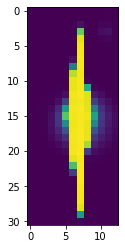

In [21]:
plt.imshow(data.tpf[300]);

Yes, that's a saturated target. Let's define our own aperture and go forth.

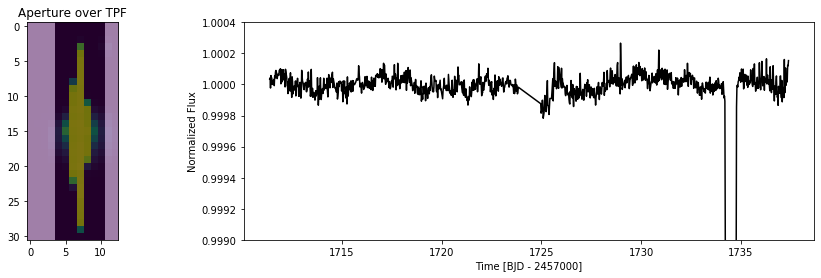

In [22]:
ap = np.zeros_like(data.tpf[300])

ap[:,4:11] = 1


data.get_lightcurve(aperture=ap)
q = data.quality == 0

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax2.plot(data.time[q], data.corr_flux[q]/np.nanmedian(data.corr_flux[q]) - 0.0, 'k')
ax2.set_ylim(0.999, 1.0004)
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

Alpha draconis, with $V=3.7$, has a deep secondary eclipse as reported in Bedding et al. (2020), and the star is so bright the photon noise is at the few ppm level on 30-minute timescales.

It often works very well for bright, saturated targets to use additional regressors, drawing on the corner pixels of the TPF to use on the detrending. An example of this is below.

#### 1.7 Putting it all together: recovering $\pi$ Men c

Let's make sure we can recover the planet discovered with TESS data around the bright star $\pi$ Mensae, combining what we have learned about saturated targets with the addition of regressing against corner pixels in the TPF for improved background subtraction.

In [23]:
star = eleanor.Source(name='pi Mensae', sector=1)
data = eleanor.TargetData(star, height=21, width=13)

INFO: Found cached file /Users/bmontet/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-2-cal-1588-0268_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-2-cal-1588-0268_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file /Users/bmontet/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-2-cal-1588-0268_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-2-cal-1588-0268_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file /Users/bmontet/.eleanor/mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-4-2-cal-1588-0268_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-4-2_tess_v2_pm.txt with expected size 239144. [astroquery.query]


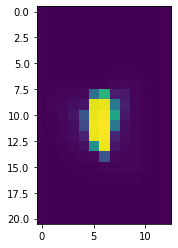

In [24]:
plt.imshow(data.tpf[300]);

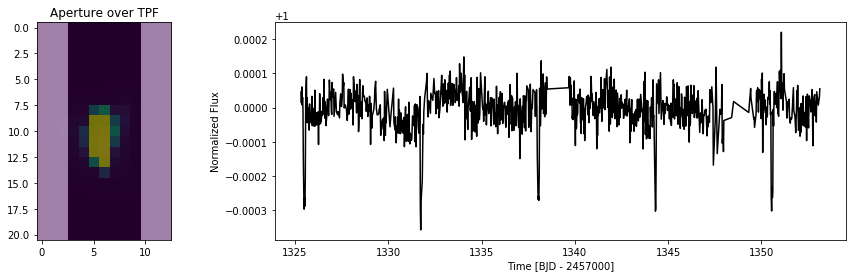

In [25]:
ap = np.zeros_like(data.tpf[300])
ap[:,3:10] = 1


data.get_lightcurve(aperture=ap)
corr_flux = eleanor.TargetData.corrected_flux(data, flux=data.raw_flux, regressors='corner')
q = data.quality == 0

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax2.plot(data.time[q], corr_flux[q]/np.nanmedian(corr_flux[q]) - 0.0, 'k')
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');


It looks like there's a planet here! Let's fold on the known period and phase:

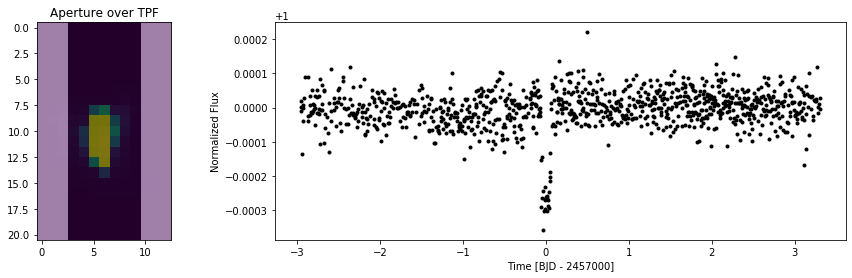

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax1.imshow(data.tpf[0])
ax1.imshow(data.aperture, cmap='Greys', alpha=0.5)
ax1.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

modtime = np.mod(data.time[q], 6.268)-2.96

ax2.plot(modtime, corr_flux[q]/np.nanmedian(corr_flux[q]) - 0.0, 'k.')
ax2.set_xlabel('Time [BJD - 2457000]')
ax2.set_ylabel('Normalized Flux');

There it is!

#### 1.8 Updating eleanor

`eleanor` should not need a version upgrade to handle new sectors of data. Calling `eleanor.Source` on a new sector of data should download all the required metadata to produce light curves for that sector. If you are getting errors, it is worth trying to remove the `~/.eleanor/metadata/sNNNN` directory, where `NNNN` corresponds to the sector in question and trying again. You can also try explicitly acquiring the metadata for a given sector by calling `eleanor.Update()`. This shouldn't take long, but the exact time will depend on the strength of your internet connection.

In [27]:
eleanor.Update(sector=20);

Inflating...
This is the first light curve you have made for this sector. Getting eleanor metadata products for Sector 20...
This will only take a minute, and only needs to be done once. Any other light curves you make in this sector will be faster.
Target Acquired
Cadences Calculated
Quality Flags Assured
CBVs Made
Success! Sector 20 now available.


#### 1.8 Other tips, tricks, or hacks

This is of course an incomplete list of things that work to optimise the creation or interepretation of TESS FFI light curves. If you have any other ones, let us know! This tutorial lives as a Jupyter notebook on the `eleanor` GitHub repository; pull requests are welcomed!